## Pytorch Computer Vision

## 0. Computer vision libraries in PyTorch 

* `torchvision` - base domain library for PyTorch computer vision
* `torchvision.datasets` - get datasets and data loading functions for CV
* `torchvision.models` - get pretrained computer vision models
* `torchvision.transforms` - functions for manipulation vision data for use in an ML model
* `torch.utils.data.Dataset` - Base dataset class for PyTorch
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset

In [2]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision 
from torchvision import datasets 
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib
import matplotlib.pyplot as plt

# Set device
device = "mps" if torch.backends.mps.is_available() else "cpu"

# Check version
print(torch.__version__)
print(torchvision.__version__)
print(device)

2.5.1
0.20.1
mps


## 1. Getting a dataset

We will be using FashionMNIST

In [3]:
train_data = datasets.FashionMNIST(
    root="data", #save here
    train=True, #get the training dataset
    download=True, #download it
    transform=torchvision.transforms.ToTensor(), #transform dataset with this method
    target_transform=None #no transform for the target labels
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False, 
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

len(train_data), len(test_data)

100.0%


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



(60000, 10000)

### 1.1 Check dimensions of our data

In [ ]:
image, label = train_data[0]
class_names = train_data.classes

print(f"Image shape: {image.shape} -> [color channels, height, width]")
print(f"Image label: {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color channels, height, width]
Image label: Ankle boot


### 1.2 Visualizing our data

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

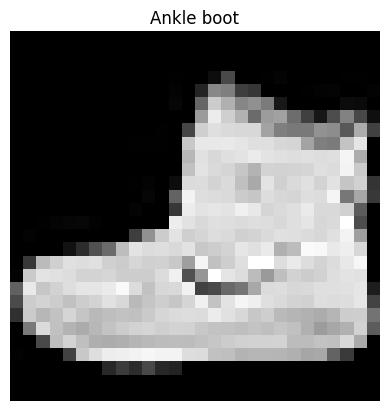

In [18]:
#plt.imshow(image.view(28, 28), cmap="grey") # works too, but squeeze is better
plt.imshow(image.squeeze(), cmap="grey")
plt.title(class_names[label])
plt.axis(False)


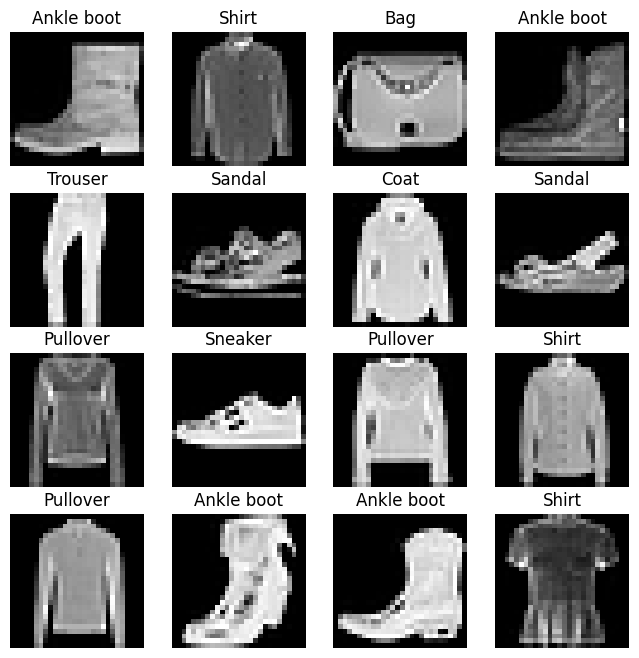

In [27]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(8, 8))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="grey")
    plt.title(class_names[label])
    plt.axis(False)

## 2. Prepare DataLoader

Right now our data are in the form of PyTorch tensors. A DataLoader turns our dataset into a Python iterables.

We want to turn our data into batches (or mini-batches).

Why?

1. It is computationally more efficient, as our HW is most likely not able to store 60000 images in memory. So we break it down to 32 images at a time (batch size of 32).
2. It gives out neural network more chances to updates its gradients per epoch.

In [28]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Train datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x323faa9f0>,
 <torch.utils.data.dataloader.DataLoader at 0x32439f500>)

In [29]:
# Let's check what we have created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} of {BATCH_SIZE}.")
print(f"Length of test dataloader: {len(test_dataloader)} of {BATCH_SIZE}.")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x323faa9f0>, <torch.utils.data.dataloader.DataLoader object at 0x32439f500>)
Length of train dataloader: 1875 of 32.
Length of test dataloader: 313 of 32.


In [40]:
# Check out what is inside the dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 0, label size: torch.Size([])


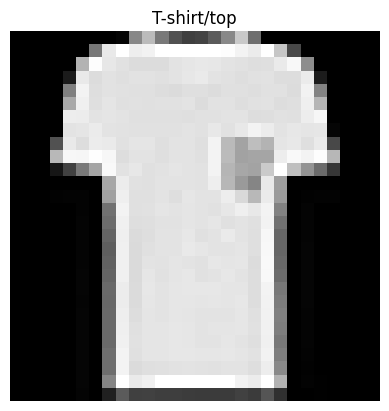

In [45]:
# Show a saple
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3. Model 0: Build a baseline model

Best practice in ML is to start with a base model, which you improve on with subsequent models/experiments. Start simple and introduce complexity as necessary.